# STORE SALES PREDICTIONS

# 1. BUSINESS UNDERSTANDING

### 1.1. Business objectives

Store managers are tasked with **predicting their daily sales for up to six weeks in advance**.

### 1.2. Assess situation

Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### 1.3. Project goals

This project intends to build a regression model to predict daily sales up to 6 weeks ahead using machine learning algorithms.

# 2. DATA UNDERSTANDING

### 2.1. Import libraries and helper functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import pickle
import xgboost as xgb
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from boruta                  import BorutaPy

def jupyter_settings():
    %matplotlib inline 
    %pylab inline
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=10
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 2.2. Collect initial data

In [2]:
# Loading data
df_raw_store = pd.read_csv('../data/store.csv', low_memory=False)
df_raw_train = pd.read_csv('../data/train.csv', low_memory=False)

# Merging
df = pd.merge(df_raw_train, df_raw_store, how='left', on='Store')

# Snakecase pattern
columns_old = list(df.columns)
snakecase = lambda x: inflection.underscore(x)
columns_new = map(snakecase, columns_old)
df.columns = columns_new

# Dataset
df1 = df.copy()

### 2.3. Describe data

In [3]:
# Visualizing dataset
display(df1.head())
display(df1.tail())

# Data info
display(df1.info())

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

None

### 2.4. Explore data

### 2.4.1. Numerical attributes

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1014567.0,5430.085652,7715.323700,20.0,710.0,2330.0,6890.0,75860.0
competition_open_since_month,693861.0,7.222866,3.211832,1.0,4.0,8.0,10.0,12.0
competition_open_since_year,693861.0,2008.690228,5.992644,1900.0,2006.0,2010.0,2013.0,2015.0


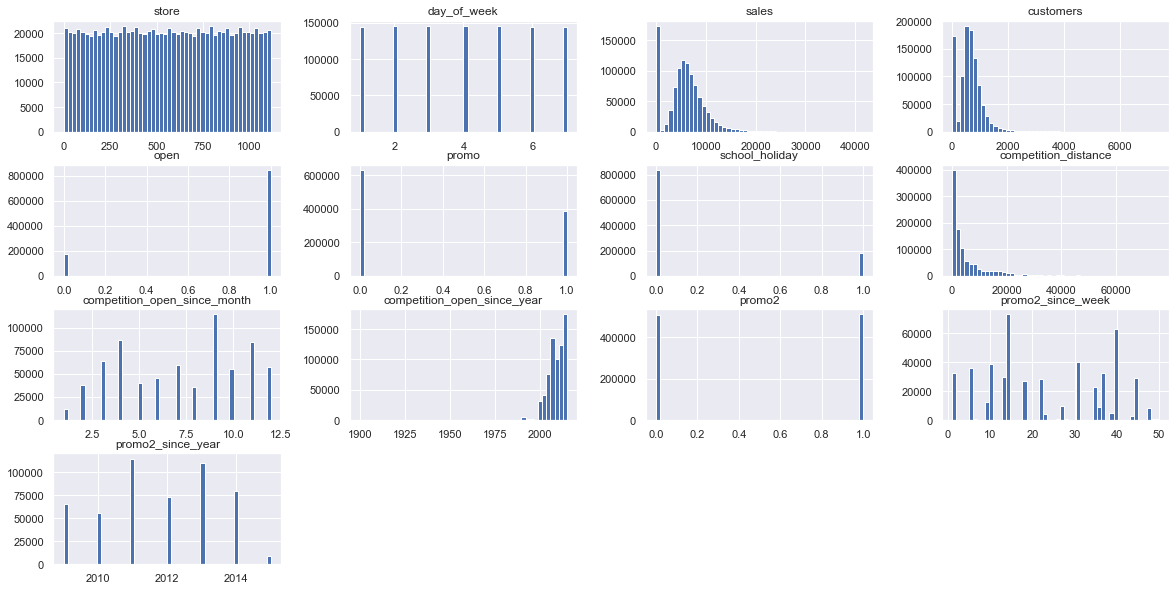

In [4]:
# Numerical attributes
num_attributes = df1.select_dtypes( include = ['int64','float64'] )
display(num_attributes.describe().T)
num_attributes.hist(bins=50);

### 2.4.2. Datetime attribute

Lowest date: 2013-01-01 00:00:00
Biggest date: 2015-07-31 00:00:00


<AxesSubplot:xlabel='date', ylabel='sales'>

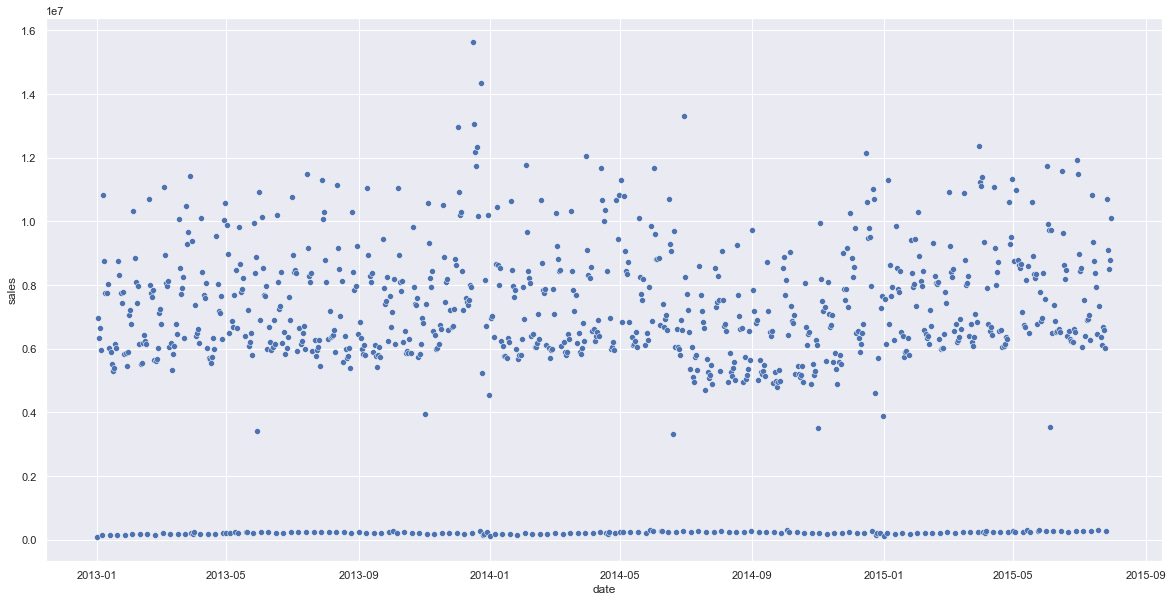

In [5]:
# Datetime attributes
df1['date'] = pd.to_datetime( df1['date'])

# Lowest date
print('Lowest date: {}'.format(df1['date'].min() ) )

# Biggest date
print('Biggest date: {}'.format(df1['date'].max() ) )

#Visualizing date by sales
aux = df1[['date', 'sales']].groupby('date').sum().reset_index()
sns.scatterplot(x='date', y='sales', data=aux)

### 2.4.3. Categorical attributes

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot:xlabel='promo_interval', ylabel='sales'>

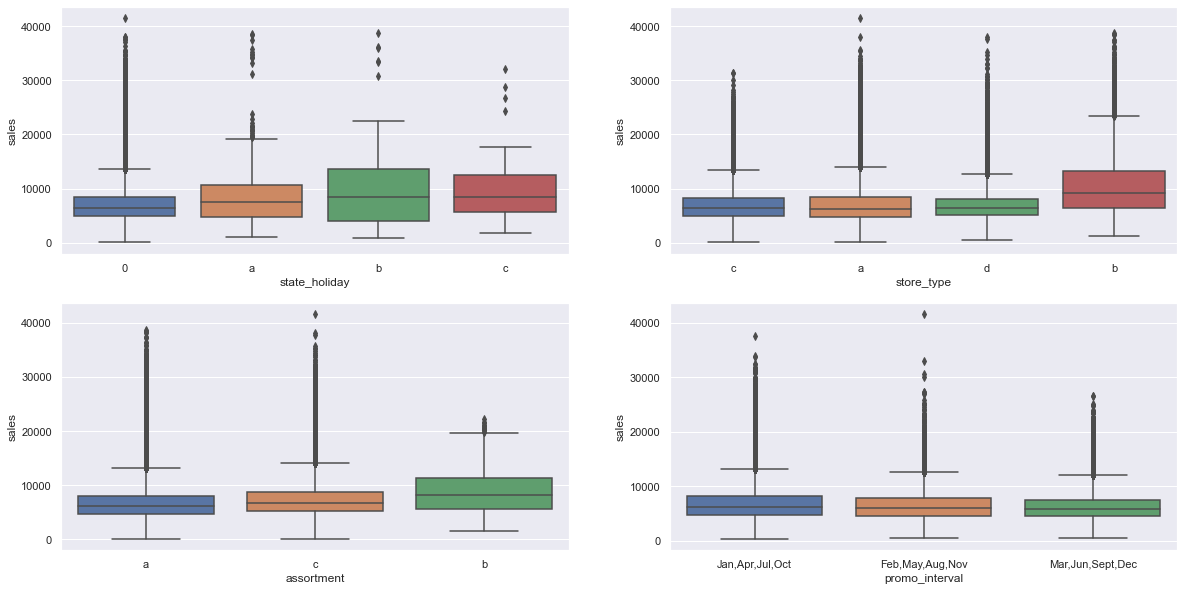

In [6]:
# Categorical attributes
cat_attributes = df1.select_dtypes( exclude = ['int64','float64', 'datetime'] )
display( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

# Visualizing categorical by sales
aux = df1[ df1['sales'] > 0 ]

plt.subplot(2, 2, 1)
sns.boxplot(x='state_holiday', y= 'sales', data= aux)

plt.subplot(2, 2, 2)
sns.boxplot(x='store_type', y= 'sales', data= aux)

plt.subplot(2, 2, 3)
sns.boxplot(x='assortment', y= 'sales', data= aux)

plt.subplot(2, 2, 4)
sns.boxplot(x='promo_interval', y= 'sales', data= aux)

### 2.5. Verify data quality

In [7]:
# Checking NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 3. DATA PREPARATION

### 3.1. Select data

In [8]:
# Dataset
df2 = df1.copy()

# Dropping 'customers' -> It won't be available on the moment of predictions (test dataset)
df2.drop('customers', axis=1, inplace=True)

# Excluding rows where 'open'== 0 and 'sales' == 0 -> the store wasn't working or there are no sales 
df2 = df2[ (df2['open'] != 0) & (df2['sales'] > 0)]

# Dropping 'open' -> It is not necessary anymore
df2.drop('open', axis=1, inplace=True)

### 3.2. Clean data

In [9]:
# Fillout NAs

# ['competition_distance'] -> NA can means there is no competitor store near. 
# Filling with the highest value (75860)
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 75860 if math.isnan(x) else x )

# ['competition_open_since_(month/year)']
# Filling with the month/year of sale's date ('date'.month / 'date'.year)
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df2['competition_open_since_year']  = df2.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# ['promo2_since_(year/week)'] -> NA occur when store is not participating to 'promo2' (promo2 == 0)
# Filling with the year/week of sale's date ('date'.year / 'date'.week)
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ['promo_interval'] -> NA occur when store is not participating to 'promo2' (promo2 == 0)
# Filling with zero 
df2['promo_interval'].fillna(0, inplace=True)

### 3.3. Construct data

In [10]:
# Dataset
df3 = df2.copy()

# Deriving 'date' of sale
df3['year']  = df3['date'].apply( lambda x: x.year )
df3['month'] = df3['date'].apply( lambda x: x.month )
df3['day']   = df3['date'].apply( lambda x: x.day )

# Deriving 'competition_open_since_(month/year)' to indicate the time of competition related to date of sale
df3['competition_open_since'] = df3.apply(lambda x: datetime.datetime(
    day=1,
    month= int(x['competition_open_since_month']),
    year= int(x['competition_open_since_year'])), axis=1 )
df3['competition_time'] = df3['competition_open_since'] - df3['date']

# Deriving 'promo2_since_(week/year)' to indicate the time of participation in the promo2 related to date of sale
df3['promo2_since'] = df3.apply( lambda x: str(int(x['promo2_since_year'])) + '-' + str(int(x['promo2_since_week'])), axis=1 )
df3['promo2_since'] = df3.apply( lambda x: datetime.datetime.strptime( x['promo2_since']+'-1', '%Y-%W-%w' ), axis=1 )
df3['promo2_time'] = df3['promo2_since'] - df3['date']

# Deriving 'promo_interval' to indicate if promo2 was activated on date of sale
dict_promo_interval = {'Jan,Apr,Jul,Oct':  [1, 4, 7, 10],
                       'Feb,May,Aug,Nov':  [2, 5, 8, 11],
                       'Mar,Jun,Sept,Dec': [3, 6, 9, 12],
                       0: [0]}
df3['promo_interval'] = df3['promo_interval'].map(dict_promo_interval)
df3['promo2_activated'] = df3.apply( lambda x: 1 if ( x['month'] in x['promo_interval'] ) else 0, axis=1 )

# Dropping attributes that have been replaced by derived variables
cols_to_drop = ['competition_open_since_month','competition_open_since_year', 'competition_open_since',
                'promo2_since_week', 'promo2_since_year', 'promo2_since', 'promo_interval']
df3.drop(cols_to_drop, axis=1, inplace=True)

### 3.4. Format data

In [11]:
# Reorganizing dataset
df4 = df3.copy()
df4 = df4[['store', 'sales', 'date', 'year', 'month', 'day', 'day_of_week', 'state_holiday',
           'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_time',
           'promo', 'promo2', 'promo2_time', 'promo2_activated']]

#Verifying types
df4.dtypes

store                             int64
sales                             int64
date                     datetime64[ns]
year                              int64
month                             int64
day                               int64
day_of_week                       int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_time        timedelta64[ns]
promo                             int64
promo2                            int64
promo2_time             timedelta64[ns]
promo2_activated                  int64
dtype: object

In [12]:
# Changing data type - converting timedelta to integer
df4['competition_time'] = df4['competition_time'].apply( lambda x: int(x.days) )
df4['promo2_time'] = df4['promo2_time'].apply( lambda x: int(x.days) )

### 3.5. Rescaling

In [13]:
# Dataset
df5 = df4.copy()

# Robust Scaler
robust_scaler = RobustScaler()
df5[['competition_distance', 'competition_time', 'promo2_time']] = robust_scaler.fit_transform( df5[['competition_distance', 'competition_time', 'promo2_time']] )

# Min Max Scaler
minmax_scaler = MinMaxScaler()
df5['year'] = minmax_scaler.fit_transform( df5['year'].values.reshape(-1,1) )

### 3.6. Encoding

In [14]:
# 'state_holiday' - one hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# 'store_type' - label encoding
df5['store_type'] = LabelEncoder().fit_transform( df5['store_type'] )

# 'assortment' - ordinal encoding
assortment_dict = {'a':1, 'b':2, 'c':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 3.7. Transformations

In [15]:
# Logarithmic Transformation
df5['sales'] = np.log1p( df5['sales'] )

In [16]:
# Cyclic Transformation 
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) ) 
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31) ) ) 
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31) ) ) 

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) ) 

# Dropping cyclically transformed attributes
df5.drop(['month', 'day', 'day_of_week'], axis=1, inplace=True)

# 4. MODELING

### 4.1. Split dataset into train and test

In [17]:
# Sort dataset by date in ascending order
df6 = df5.copy()
df6 = df6.sort_values(by='date', ascending=True).reset_index(drop=True)

# Separate the data from the last 6 weeks for test dataset and the others for training dataset
date_start_last_6_weeks = df6['date'].max() - datetime.timedelta(days=6*7)

df6_train = df6[ df6['date'] < date_start_last_6_weeks ]

df6_test = df6[ df6['date'] >= date_start_last_6_weeks ]

X_train = df6_train.drop(['sales', 'date'], axis=1)
y_train = df6_train['sales']

X_test = df6_test.drop(['sales', 'date'], axis=1)
y_test = df6_test['sales']

### 4.2. Feature Selector - Boruta

In [18]:
## Training and test dataset for Boruta
#X_train_boruta = X_train.values
#y_train_boruta = y_train.values.ravel()
#
## Defining Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## Defining Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_boruta, y_train_boruta )

In [19]:
## Best features
#cols_selected = boruta.support_.tolist()
#
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.tolist()
#
## Features not selected
#cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, cols_selected_boruta) )

In [20]:
#cols_selected_boruta

In [21]:
cols_selected_boruta = ['store',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_time',
                        'promo',
                        'promo2',
                        'promo2_time',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']
                    
X_train = X_train[ cols_selected_boruta ]
X_test = X_test[ cols_selected_boruta ]

### 4.3. Build models

Training 5 models, with and without cross validation:

    1. Average (baseline model)
    2. Linear Regression 
    3. Linear Regression Regularized
    4. Random Forest Regressor
    5. XGBoost Regressor    

In [22]:
# Model's Performance Function
def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# Cross Validation Function with Time Series Split
def cross_validation(x_training, y_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    tscv = TimeSeriesSplit(n_splits=kfold)
    for fold, (train_index, test_index) in enumerate(tscv.split(x_training)):
        print('FOLD:', fold)
        print('TRAIN:', train_index)
        print('TEST:', test_index)
        x_training_cv   = x_training.iloc[train_index]
        y_training_cv   = y_training.iloc[train_index]
        x_validation_cv = x_training.iloc[test_index]
        y_validation_cv = y_training.iloc[test_index]
        
        # model
        m = model.fit(x_training_cv, y_training_cv)
        # predict
        yhat = m.predict(x_validation_cv)
        # performance
        m_result = ml_error(model_name, np.expm1(y_validation_cv), np.expm1(yhat))
        # store performance of each Kfolds iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV':  np.round(np.mean(mape_list),2).astype(str) + '+/-' +  np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV':  np.round(np.mean(rmse_list),2).astype(str) + '+/-' +  np.round(np.std(rmse_list),2).astype(str)},index=[0])

### 4.3.1. Average

In [23]:
# Model
aux = df6_test[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux = pd.merge(df6_test, aux, how='left', on='store')

# Prediction
yhat_baseline = aux['predictions']

# Performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 4.3.2. Linear Regression

In [24]:
# Model
lr = LinearRegression().fit( X_train, y_train )

# Prediction
yhat_lr = lr.predict( X_test )

# Performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1883.242201,0.285873,2728.033928


In [25]:
# Performance with Cross Validation
lr_result_cv = cross_validation(X_train, y_train, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

FOLD: 0
TRAIN: [     0      1      2 ... 133824 133825 133826]
TEST: [133827 133828 133829 ... 267647 267648 267649]
FOLD: 1
TRAIN: [     0      1      2 ... 267647 267648 267649]
TEST: [267650 267651 267652 ... 401470 401471 401472]
FOLD: 2
TRAIN: [     0      1      2 ... 401470 401471 401472]
TEST: [401473 401474 401475 ... 535293 535294 535295]
FOLD: 3
TRAIN: [     0      1      2 ... 535293 535294 535295]
TEST: [535296 535297 535298 ... 669116 669117 669118]
FOLD: 4
TRAIN: [     0      1      2 ... 669116 669117 669118]
TEST: [669119 669120 669121 ... 802939 802940 802941]


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2002.3+/-95.97,0.3+/-0.01,2895.62+/-185.92


### 4.3.3. Linear  Regression Regularized

In [26]:
# Model
lrr = Lasso(alpha=0.01).fit( X_train, y_train )

# Prediction
yhat_lrr = lrr.predict( X_test )

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1902.27378,0.288974,2766.81268


In [27]:
# Performance with Cross Validation
lrr_result_cv = cross_validation(X_train, y_train, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

FOLD: 0
TRAIN: [     0      1      2 ... 133824 133825 133826]
TEST: [133827 133828 133829 ... 267647 267648 267649]
FOLD: 1
TRAIN: [     0      1      2 ... 267647 267648 267649]
TEST: [267650 267651 267652 ... 401470 401471 401472]
FOLD: 2
TRAIN: [     0      1      2 ... 401470 401471 401472]
TEST: [401473 401474 401475 ... 535293 535294 535295]
FOLD: 3
TRAIN: [     0      1      2 ... 535293 535294 535295]
TEST: [535296 535297 535298 ... 669116 669117 669118]
FOLD: 4
TRAIN: [     0      1      2 ... 669116 669117 669118]
TEST: [669119 669120 669121 ... 802939 802940 802941]


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2014.92+/-93.43,0.3+/-0.01,2931.42+/-171.86


### 4.3.4. Random Forest Regressor

In [28]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# Prediction
yhat_rf = rf.predict( X_test )

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,809.573678,0.12109,1185.421156


In [29]:
# Performance with Cross Validation
rf_result_cv = cross_validation(X_train, y_train, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

FOLD: 0
TRAIN: [     0      1      2 ... 133824 133825 133826]
TEST: [133827 133828 133829 ... 267647 267648 267649]
FOLD: 1
TRAIN: [     0      1      2 ... 267647 267648 267649]
TEST: [267650 267651 267652 ... 401470 401471 401472]
FOLD: 2
TRAIN: [     0      1      2 ... 401470 401471 401472]
TEST: [401473 401474 401475 ... 535293 535294 535295]
FOLD: 3
TRAIN: [     0      1      2 ... 535293 535294 535295]
TEST: [535296 535297 535298 ... 669116 669117 669118]
FOLD: 4
TRAIN: [     0      1      2 ... 669116 669117 669118]
TEST: [669119 669120 669121 ... 802939 802940 802941]


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,967.02+/-89.5,0.14+/-0.01,1521.67+/-184.72


### 4.3.5. XGBoost Regressor

In [30]:
# Model
model_xgb = xgb.XGBRegressor().fit(X_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict( X_test )

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,985.525105,0.147414,1411.48391


In [31]:
# Performance with Cross Validation
xgb_result_cv = cross_validation(X_train, y_train, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

FOLD: 0
TRAIN: [     0      1      2 ... 133824 133825 133826]
TEST: [133827 133828 133829 ... 267647 267648 267649]
FOLD: 1
TRAIN: [     0      1      2 ... 267647 267648 267649]
TEST: [267650 267651 267652 ... 401470 401471 401472]
FOLD: 2
TRAIN: [     0      1      2 ... 401470 401471 401472]
TEST: [401473 401474 401475 ... 535293 535294 535295]
FOLD: 3
TRAIN: [     0      1      2 ... 535293 535294 535295]
TEST: [535296 535297 535298 ... 669116 669117 669118]
FOLD: 4
TRAIN: [     0      1      2 ... 669116 669117 669118]
TEST: [669119 669120 669121 ... 802939 802940 802941]


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1123.41+/-121.59,0.16+/-0.01,1664.36+/-242.23


### 4.4. Assess model

### 4.4.1. Compare Single Models Performance

In [32]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,809.573678,0.121090,1185.421156
0,XGBoost Regressor,985.525105,0.147414,1411.483910
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1883.242201,0.285873,2728.033928
0,Linear Regression - Lasso,1902.273780,0.288974,2766.812680


### 4.4.2. Compare Cross Validated Models Performance

In [33]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,967.02+/-89.5,0.14+/-0.01,1521.67+/-184.72
0,XGBoost Regressor,1123.41+/-121.59,0.16+/-0.01,1664.36+/-242.23
0,Linear Regression,2002.3+/-95.97,0.3+/-0.01,2895.62+/-185.92
0,Linear Regression - Lasso,2014.92+/-93.43,0.3+/-0.01,2931.42+/-171.86


### 4.4.3. Chosen Model -> XGBoost Regressor

Comparing the metrics above, the model that achieved the best performance was Random Forest Regressor.
However the **XGBoost Regressor** has achieved similar performance and it is lighter than Random Forest to be carried.

### 4.5. Hyperparameter Fine Tuning - Random Search

In [37]:
## Parameters Variability
#param = {'n_estimators':[1500,1700,2500,3000],
#         'eta':[0.01,0.03],
#         'max_depth':[3,5,7],
#         'subsample':[0.3,0.5,0.7],
#         'colsample_bytree':[0.3,0.5,0.7],
#         'min_child_weight':[3,5,7]}
#
## Random Search 
#tscv = TimeSeriesSplit(n_splits=5)
#rscv = RandomizedSearchCV( estimator=model_xgb, param_distributions=param, n_iter=5, n_jobs=-1, cv=tscv, random_state=42, verbose=True)
#model_xgb_tuned = rscv.fit(X_train, y_train)
#model_xgb_tuned.best_params_

### 4.6. Final Model

In [38]:
param_tuned = {'n_estimators':3000,
                'eta':0.03,
                'max_depth':5,
                'subsample':0.7,
                'colsample_bytree':0.7,
                'min_child_weight':3}

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight =param_tuned['min_child_weight']).fit(X_train,y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor Tuned',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned    

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,865.072097,0.129818,1239.615788


In [39]:
# Save trained model
pickle.dump( model_xgb_tuned, open( '../model/model_store_sales_prediction.pkl', 'wb') )

# 5. EVALUATION

In [49]:
# Dataset to evaluation
df7 = df6_test.copy()
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_xgb_tuned)

# Sum of predictions
df7_aux = df7[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df7_aux1 = df7[['store','predictions','sales']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df7_aux2 = df7[['store','predictions','sales']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df7_aux3 = pd.merge(df7_aux1,df7_aux2,how='inner',on='store')
df7_aux4 = pd.merge(df7_aux,df7_aux3,how='inner',on='store')

# Scenarios
df7_aux4['worst_scenario'] = df7_aux4['predictions'] - df7_aux4['MAE']
df7_aux4['best_scenario'] = df7_aux4['predictions'] + df7_aux4['MAE']

# Order columns
df7_aux4 = df7_aux4[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df7_aux4

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,169300.937500,168976.626947,169625.248053,324.310553,0.075065
1,2,179801.234375,179368.365538,180234.103212,432.868837,0.085957
2,3,274302.468750,273477.867385,275127.070115,824.601365,0.112619
3,4,344552.687500,343651.960647,345453.414353,900.726853,0.086099
4,5,179075.750000,178598.485550,179553.014450,477.264450,0.112931
...,...,...,...,...,...,...
1110,1111,184375.062500,183598.327887,185151.797113,776.734613,0.175338
1111,1112,354650.750000,353336.671875,355964.828125,1314.078125,0.164717
1112,1113,250180.812500,249571.012906,250790.612094,609.799594,0.093490
1113,1114,756161.312500,753328.287690,758994.337310,2833.024810,0.118787


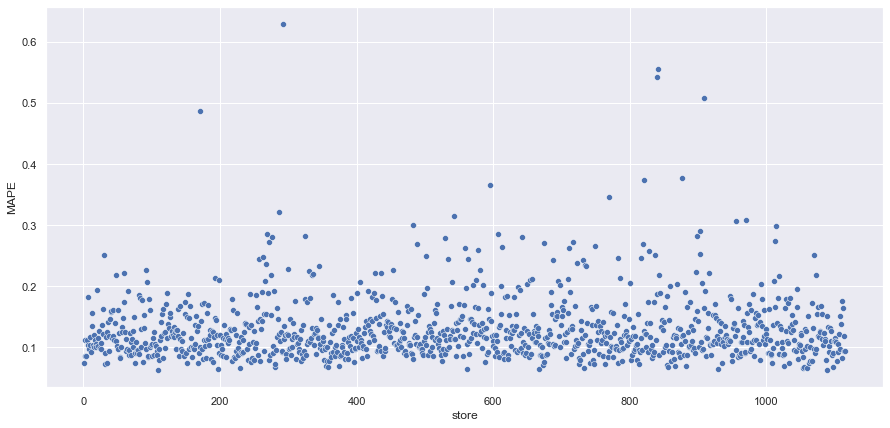

In [50]:
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'store',y = 'MAPE', data = df7_aux4);

In [51]:
# Total Business Impact
df7_aux5 = df7_aux4[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index': 'Scenarios',0:'Values'})
df7_aux5['Values'] = df7_aux5['Values'].map('R$ {:,.2f}'.format)
df7_aux5

,Scenarios,Values
0,predictions,"R$ 287,229,504.00"
1,worst_scenario,"R$ 286,262,244.44"
2,best_scenario,"R$ 288,196,758.92"


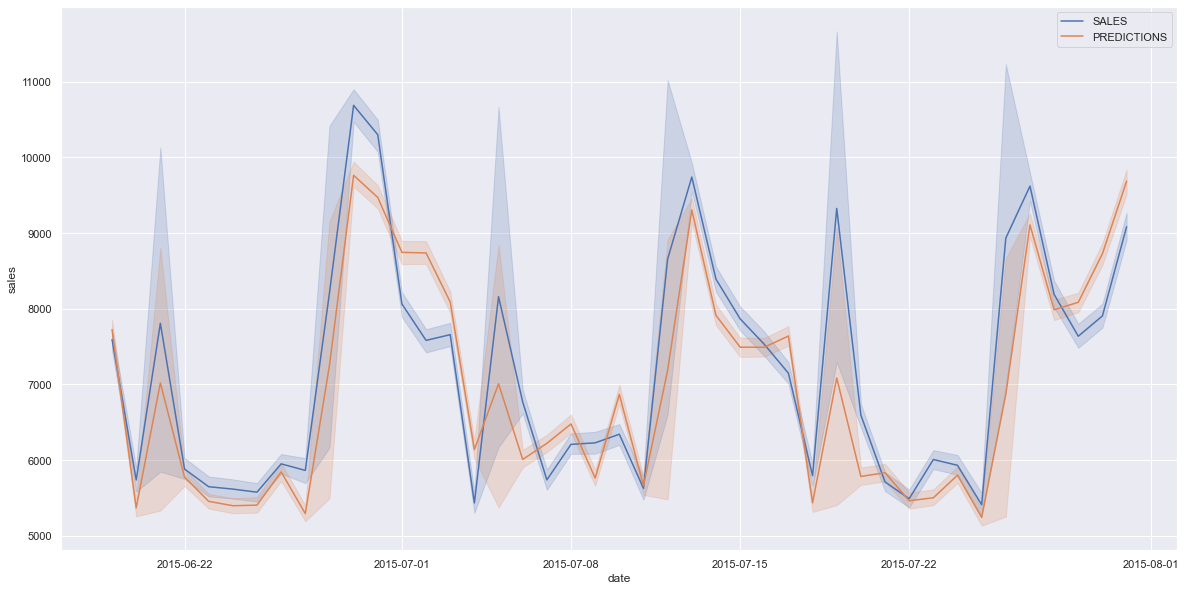

In [52]:
# Machine Learning Performance
sns.lineplot(x='date',y='sales',data=df7,label='SALES');
sns.lineplot(x='date',y='predictions',data=df7,label='PREDICTIONS');